<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Part 2: Computing the QDF**

Having demosntrated how to construct the CDF $F_Y(y)$ of a random function $Y(\boldsymbol{x})$ we now develop a means to obtain the inverse CDF $F^{-1}_Y(p)$ also known as the quantile density function or QDF $Q_Y(p)$. When estimating the available potential energy (APE) of a random function $Y(\boldsymbol{x})$, the QDF of domain height is used to account for how much of this field is located at each height and thus forms an essential component of the calculation (cf. [Winters et al.](https://doi.org/10.1017/S002211209500125X)).

To demonstrate our method of constructing the QDF, we choose the function $Y(x_1) = x$ on the interval $x_1 \in [0,1]$. To further simplify the presentation we will use the *Ptp* class (imported below) to obtain the CDF of this function.

In [14]:
from chist import Ptp
import numpy as np
from firedrake import *
from firedrake.__future__ import interpolate

We begin by creating an instance of the *Ptp* class by specify the phyiscal domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. By default the 'DG1' function space is selected for the CDF and 'CG1' for the PDF. We will later argue that "DG1" is a natural choice for $F$ and 'CG1' a natural choice for the QDF $Q$.

In [15]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (0, 1)}, Omega_Y = {'Y': (0, 1)}, n_elements=3)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain and generate its CDF and PDF by calling the fit method here (with an intentinally small quadrature degree)

In [16]:
# Extract the coordinates
x1 = ptp.x_coords()
density = ptp.fit(Y = x1, quadrature_degree=10)


firedrake:WARNING Calculated ∫ f(y) dy should equal 1, but got 9.799796e-01.
                     Check the quadrature_degree used.


Once fitted we can then plot the CDF functions by calling the plot method

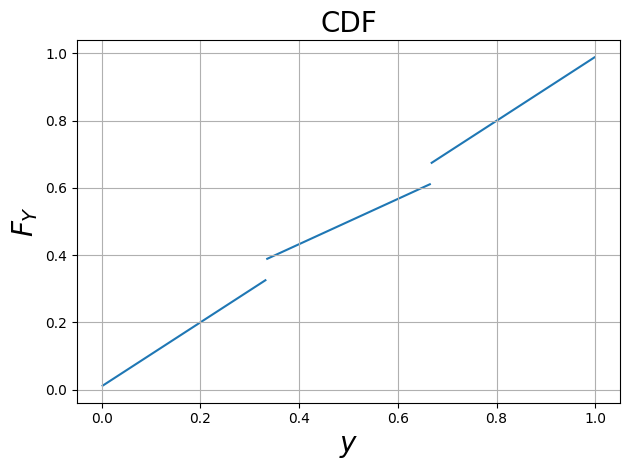

In [17]:
density.plot(function='CDF')

By choosing a small number of elements and a similarly low order quadrature we have intentionally generated a poor approximation of the CDF, which although non-decreasing is discontinous between cells. Importantly this example highlights that well mixed regions of the CDF exist for which one value of $y*$ has associated to it a range of probabilities $\Omega^*_Y = [\text{min}(F_Y(y*)),\text{max}(F_Y(y*))]$. To obtain a consistent QDF we must therefore construct a function capable of mapping $Q_Y : p \to \Omega^*_Y$. 

To obtain such a function we shall let the discontinuities of $F_Y$ determine the mesh spacing of the non-uniform mesh $\Omega_p$, on which the piecewise linear function $Q_Y(p)$ is defined. As such we use the dofs $F_i = F(y_i)$ at the node values $y_i$ on the cell boundaries to prescribe the non-uniform mesh $\Omega_p$.

In [18]:
# Construct the non-uniform domain Ω_p

# Obtain dofs F_i = F(z_i) from the CDF
F_i = density.cdf.dat.data[:] 

# We extend Ω_p to include the endpoints 0,1
# As F(y=0) ≠ 0 & F(y=1) ≠ 1 due to numerical error  
p   = np.hstack(( [0]     ,F_i,[1]       ))  

# Make a 1D mesh whose vertices are given by the p values
layers   = len(p[1:] - p[:-1]);
m_p = UnitIntervalMesh(ncells=layers);
m_p.coordinates.dat.data[:] = p[:]

print('Ω_p cell boundaries = ',m_p.coordinates.dat.data[:])

Ω_p cell boundaries =  [0.         0.0100102  0.32701903 0.38787271 0.61212729 0.67298097
 0.9899898  1.        ]


Having constructed the mesh $\Omega_p$ we then define the function $Q_Y(p)$, by using the function space $V_f$ as specified by the finite element *V_fE* whose details are printed below.

In [23]:
# Create a function Q(p) on this mesh
V_Q  = FunctionSpace(mesh=m_p,family=ptp.V_fE)
Q    = Function(V_Q)

print(V_Q.ufl_function_space)

<bound method WithGeometryBase.ufl_function_space of WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x773e8149bfa0>, FiniteElement('Lagrange', interval, 1, variant='equispaced'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 70))>


Finally we set the values of the QDF $Q_Y(F_i) = Q_Y(F(y_i)) = y_i$ by passing it the $y_i$ coordinates of the CDF's mesh corresponding to each $F_i$.

In [25]:
# Extract the mesh coordinates of the CDF
m_y = ptp.V_F.mesh()
w = VectorFunctionSpace(m_y, ptp.V_F.ufl_element())
y_m = assemble(interpolate(m_y.coordinates, w)).dat.data

# Append the coordinates of the boundaries
y_l = m_y.coordinates.dat.data[0]  # left endpoint
y_r = m_y.coordinates.dat.data[-1]  # right endpoint
y_i = np.hstack(([y_l], y_m, [y_r]))

# Assign Q(F_i) = y_i
Q.dat.data[:] = y_i[:]

Plotting the QDF $Q_Y = F^{-1}_Y$ and comparing it with its corresponding CDF $F_Y$, we see that vertical discontinuities in $F_y$ correspond to $Q_Y$ taking a constant value. These vertical discontinuities correspond to well mixed regions, which the formulation of the QDF treats without issue. Furthermore as we increase the quadrature rule these regions do eventually disappear. By contrast a 'DG0' or binning approach will always contain these regions.

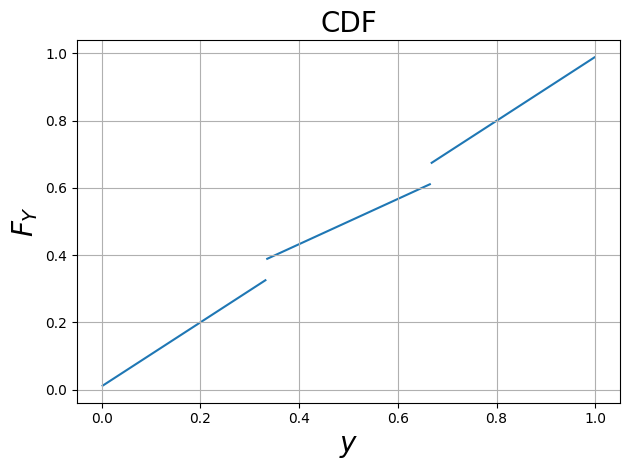

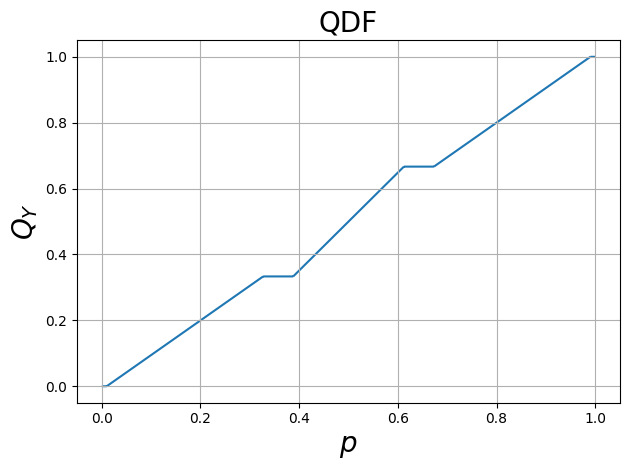

In [26]:
density.plot(function='CDF')
density.plot(function='QDF')